# 8-point Algo

In [1]:
# Imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Constants
MIN_MATCH_COUNT = 8

## Find Keypoints and Match with RANSAC

### Find keypoints and descriptors

In [2]:
def find_keypoints_and_descriptors(image_gray, detector = cv2.ORB_create(3000)):
    '''Detect keypoints in a greyscale image'''
    keypoints, descriptors = detector.detectAndCompute(image_gray, None)
    return keypoints, descriptors


### Match Points

In [3]:
# Find good matches between two sets of descriptors
def match_descriptors(des1, des2):
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)
    return good_matches


### Find inliers of matches

In [4]:
def find_homography_and_draw_matches(im1_gray, im2_gray, kp1, kp2, good_matches):
    '''Find homography between two images given the keypoints'''
    if len(good_matches) > MIN_MATCH_COUNT:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        matchesMask = mask.ravel().tolist()
    else:
        print("Not enough matches are found - {}/{}".format(len(good_matches), MIN_MATCH_COUNT))
        matchesMask = None
    
    inlier_pts1 = np.float32([kp1[m.queryIdx].pt for i, m in enumerate(good_matches) if matchesMask[i]])
    inlier_pts2 = np.float32([kp2[m.trainIdx].pt for i, m in enumerate(good_matches) if matchesMask[i]])
    
    return inlier_pts1, inlier_pts2

### Find inlier matching points between 2 images

In [5]:
def find_inlier_matching_points(im1_gray, im2_gray):
    '''Function to find inlier matching points between two images'''
    # Find the key points and descriptors in the two images
    kp1, des1 = find_keypoints_and_descriptors(im1_gray)
    kp2, des2 = find_keypoints_and_descriptors(im2_gray)

    # Match keypoints
    good_matches = match_descriptors(des1, des2)

    # Find homography and draw matches
    inlier_pts1, inlier_pts2 = find_homography_and_draw_matches(im1_gray, im2_gray, kp1, kp2, good_matches)
    # inlier_pts1 = np.float32([kp1[m.queryIdx].pt for i, m in enumerate(good_matches)])
    # inlier_pts2 = np.float32([kp2[m.trainIdx].pt for i, m in enumerate(good_matches)])
    return inlier_pts1, inlier_pts2

In [6]:
def plot_two_images_with_matches(im1, im2, inlier_pts1, inlier_pts2):
    '''Plot two images side by side with matches shown'''
    # Convert grayscale images to BGR so that we can draw colored lines
    im1_color = cv2.cvtColor(im1, cv2.COLOR_GRAY2BGR)
    im2_color = cv2.cvtColor(im2, cv2.COLOR_GRAY2BGR)

    img3 = np.hstack((im1_color, im2_color))
    for pt1, pt2 in zip(inlier_pts1, inlier_pts2):
        pt2 = (pt2[0] + im1.shape[1], pt2[1])
        cv2.line(img3, tuple(map(int, pt1)), tuple(map(int, pt2)), (0, 255, 0), 1)
        cv2.circle(img3, tuple(map(int, pt1)), 5, (0, 0, 255), -1)
        cv2.circle(img3, tuple(map(int, pt2)), 5, (0, 0, 255), -1)


    # Show the matches image
    plt.figure()
    plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
    plt.show()

### Show feature matches

c:\Users\Home\Documents\GitHub\Comp558Project\8PointAlgorithm\Reference_Render_cubes\Reference_Render_Translation\cubes_translation0001.png


TypeError: Image data of dtype object cannot be converted to float

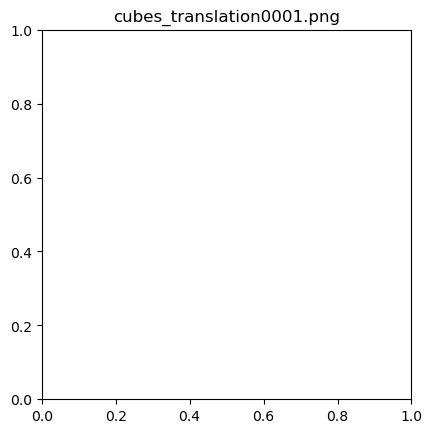

In [7]:
# load images
absolute_folder_path = os.path.join(os.getcwd(), 'Reference_Render_cubes', 'Reference_Render_Translation')
print(absolute_folder_path)
im1_name = 'cubes_translation0001.png'
im1 = cv2.imread(os.path.join(absolute_folder_path,im1_name), 3)
plt.title(im1_name)
a = plt.imshow(im1)
plt.show()

im2_name = 'cubes_translation0100.png'
im2 = cv2.imread(os.path.join(absolute_folder_path,im2_name), 3)
plt.title(im2_name)
a = plt.imshow(im2)
plt.show()

# Convert images to grayscale
im1_gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
im2_gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

# Plot 

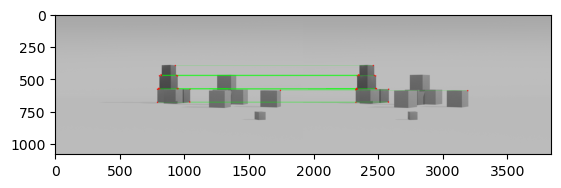

Number of matching points found: 29


In [48]:

# Compute points
pts1, pts2 = find_inlier_matching_points(im1_gray, im2_gray)

# Plot the inlier matching points
plot_two_images_with_matches(im1_gray, im2_gray, pts1, pts2)

print(f"Number of matching points found: {len(pts1)}")


## Compute the fundamental matrix

In [35]:
def compute_normalization_matrix(pts):
    """Computes the normalization matrix for the points. Assumes x,y and shape (N x 2)"""    
    # Normalize points
    pts1_mean = np.mean(pts, axis=0)
    
    pts1_std = np.std(pts) # TODO: Computes flattened std. Need to instead compute as seen in the lecture slides (https://stackoverflow.com/questions/52940822/what-is-the-correct-way-to-normalize-corresponding-points-before-estimation-of-f)
    T = np.array([[1/pts1_std, 0, -pts1_mean[0]/pts1_std],
                [0, 1/pts1_std, -pts1_mean[1]/pts1_std],
                [0, 0, 1]])
    return T
    

### Compute Fundamental Matrix

In [65]:
def compute_fundamental_matrix(pts1, pts2):
    return cv2.findFundamentalMat(pts1, pts2, cv2.RANSAC)

### Compute Essential matrix

In [66]:
def compute_essential_matrix(pts1, pts2, K):
    return cv2.findEssentialMat(pts1, pts2, K, cv2.RANSAC)

Test compute E and F

In [ ]:
# Define Intrinsic Matrix
K = np.array([[2666.666666666, 0, 960],
            [0, 2666.666666666, 540],
            [0, 0, 1]]) 
F, mask = compute_fundamental_matrix(pts1, pts2)
norm = np.linalg.norm(F)
F /= norm
print(F.shape)
E = np.matmul(np.matmul(K.T, F), K)
norm = np.linalg.norm(E)
E /= norm

E_prime, mask = compute_essential_matrix(pts1, pts2, K)
norm = np.linalg.norm(E_prime)
E_prime /= norm

print(f"E from fund = {E}")
print(f"E from direct = {E_prime}")

NameError: name 'np' is not defined

In [ ]:
from helper import apply_matrix
# Plot transformed points
transformed_pts = apply_matrix(pts1, F)


plt.title(im2_name)
a = plt.imshow(im2)
plt.scatter(x=pts2[:,0], y=pts2[:,1], c='r', label = "Base feature points")
plt.scatter(x=transformed_pts[:,0], y=transformed_pts[:,1], c='g', label ="Transformed feature points")
plt.legend(loc="upper left")
plt.show()

## Essential Matrix

In [37]:
def compute_essential_matrix(F, K):
    '''Recover essential matrix from fundamental matrix and camera intrinsic matrix'''
    E = np.matmul(np.matmul(K.T, F), K)
    return E

In [76]:
def recover_rotation_translation(E):
    U, S, Vt = np.linalg.svd(E)

    if np.linalg.det(U) < 0:
        U = -U
    if np.linalg.det(Vt) < 0:
        Vt = -Vt

    D = np.array([[0, 1, 0], [-1, 0, 0], [0, 0, 1]])
    R1 = U@D@Vt
    R2 = U@D.T@Vt
    t1 = U[:, 2]
    t2 = -U[:, 2]

    return R1, R2, t1, t2


### Disambiguate rotation and translation based on valid points and intrinsics

In [77]:
def disambiguate_rotation_translation(R1, R2, t1, t2, pts1, pts2, K):
    P1 = np.hstack((np.eye(3), np.zeros((3, 1))))
    P2_candidates = [
        np.hstack((R1, t1.reshape(-1, 1))),
        np.hstack((R1, t2.reshape(-1, 1))),
        np.hstack((R2, t1.reshape(-1, 1))),
        np.hstack((R2, t2.reshape(-1, 1))),
    ]

    max_valid_points_count = 0
    threshold = 10
    bestR = None
    bestT = None
    for i, P2 in enumerate(P2_candidates):
        points_4d_hom = cv2.triangulatePoints(P1, P2, pts1.T, pts2.T)
        points_3d = points_4d_hom[:3] / points_4d_hom[3]

        in_front_of_cam1 = points_3d[2, :] > 0
        in_front_of_cam2 = (P2 @ np.vstack((points_3d, np.ones((1, points_3d.shape[1])))))[2, :] > 0

        valid_points_count = np.sum(in_front_of_cam1 & in_front_of_cam2)

        if valid_points_count > threshold and valid_points_count > max_valid_points_count:
            print(f"Correct solution: R = {P2[:, :3]}, t = {P2[:, 3]}, valid points count = {valid_points_count}")
            max_valid_points_count = valid_points_count
            bestR = P2[:, :3]
            bestT = P2[:, 3]

    return bestR, bestT

In [85]:
R1, R2, t1, t2 = recover_rotation_translation(E_prime)
print(f"R1:{R1}, R2:{R2}, t1:{t1}, t2:{t2}")
R1, R2, t = cv2.decomposeEssentialMat(E_prime)
print(f"R1:{R1}, R2:{R2}, t{t}")

# R1, R2, t1, t2 = recover_rotation_translation(E)
# print(f"R1:{R1}, R2:{R2}, t1:{t1}, t2:{t2}")
# R1, R2, t = cv2.decomposeEssentialMat(E)
# print(f"R1:{R1}, R2:{R2}, t{t}")
bestR, bestT = disambiguate_rotation_translation(R1, R2, t1, t2, pts1, pts2, K)

R1:[[ 0.96955275  0.00716682 -0.24477767]
 [ 0.00537236  0.99870856  0.05052075]
 [ 0.24482362 -0.05029757  0.96826213]], R2:[[ 0.5974313  -0.77120336  0.21982088]
 [-0.78467744 -0.61873178 -0.03810904]
 [ 0.16539999 -0.14972095 -0.97479561]], t1:[ 0.87175307 -0.43354723  0.22821783], t2:[-0.87175307  0.43354723 -0.22821783]
R1:[[ 0.96955275  0.00716682 -0.24477767]
 [ 0.00537236  0.99870856  0.05052075]
 [ 0.24482362 -0.05029757  0.96826213]], R2:[[ 0.5974313  -0.77120336  0.21982088]
 [-0.78467744 -0.61873178 -0.03810904]
 [ 0.16539999 -0.14972095 -0.97479561]], t[[-0.87175307]
 [ 0.43354723]
 [-0.22821783]]
Correct solution: R = [[ 0.96955275  0.00716682 -0.24477767]
 [ 0.00537236  0.99870856  0.05052075]
 [ 0.24482362 -0.05029757  0.96826213]], t = [-0.87175307  0.43354723 -0.22821783], valid points count = 29


## Graph Results

In [39]:
# Display the movement of the camera in 3D space from an array of translation matrices
def display_camera_movement(t_list):
    # Enable interactive mode
    # Create a 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the origin
    ax.scatter(0, 0, 0, color='r')
    ax.text(0, 0, 0, "Camera 1")

    # Initialize the current displacement
    current_displacement = np.zeros(3)

    # Plot the camera positions
    for i, t in enumerate(t_list):
        current_displacement += t
        ax.scatter(current_displacement[0], current_displacement[1], current_displacement[2], color='b')
        ax.text(current_displacement[0], current_displacement[1], current_displacement[2], f"Camera {i+2}")

    # Set the axes limits
    ax.set_xlim([-2, 2])
    ax.set_ylim([-2, 2])
    ax.set_zlim([-2, 2])

    # Show the plot
    plt.show()

In [40]:
# Define Intrinsic Matrix
K = np.array([[2666.666666666, 0, 960],
            [0, 2666.666666666, 540],
            [0, 0, 1]]) 